# Лабораторная работа 7
## Resnet-18 на датасете Caltech256

Моисеенков И.П., М8О-408Б-19

Задание:
1. Скачать датасет Caltech256 и поделить его на трейн/тест в соответствии с файликами
2. Взять готовый Resnet-18 (не предобученный) и выбить accuracy 0.6+
3. Реализовать Resnet-18 руками и убедиться, что accuracy такой же
4. Сконвертнуть обученные модели в формат onnx
5. Убедиться, что точность модели в onnx такая же

### 1. Загрузка датасета

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
import transformers

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import os
import copy
import shutil
from pathlib import Path

In [2]:
dataset_path = "256_ObjectCategories/"
train_lst_path = "train_lst.txt"
val_lst_path = "val_lst.txt"
data_path = "data/"

Делим датасет на трейн и вал в соответствии с заданием

In [5]:
train_path = data_path + "train"

with open(train_lst_path) as f:
    for line in tqdm(f.readlines()):
        path, n, name = line.strip().split()
        folder, cls, file = path.split("/")

        class_path = os.path.join(train_path, name)
        Path(class_path).mkdir(parents=True, exist_ok=True)
        shutil.copy(dataset_path + path, os.path.join(class_path, file))

  0%|          | 0/18056 [00:00<?, ?it/s]

In [6]:
val_path = data_path + "val"

with open(val_lst_path) as f:
    for line in tqdm(f.readlines()):
        path, n, name = line.strip().split()
        folder, cls, file = path.split("/")

        class_path = os.path.join(val_path, name)
        Path(class_path).mkdir(parents=True, exist_ok=True)
        shutil.copy(dataset_path+path, os.path.join(class_path, file))

  0%|          | 0/5862 [00:00<?, ?it/s]

Создадим датасет и даталоадеры. Также прикрутим аугментацию картинок

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = dict()
dataloaders["train"] = torch.utils.data.DataLoader(image_datasets["train"], batch_size=128, shuffle=True, num_workers=3)
dataloaders["val"] = torch.utils.data.DataLoader(image_datasets["val"], batch_size=128, shuffle=False, num_workers=3)
class_names = image_datasets['train'].classes

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Посмотрим на примеры картинок

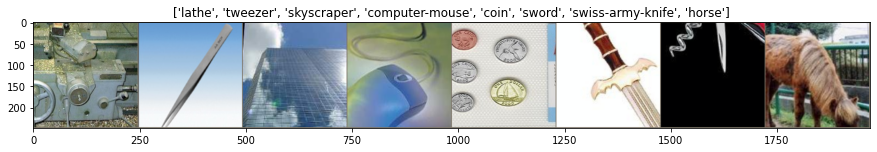

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Достанем несколько картинок из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in classes[:8]])

У каждого класса разное количество фоток, поэтому будем использовать веса для классов при вычислении лосса.

In [10]:
сlass_shares = np.zeros(len(class_names))

for cur_target in image_datasets['train'].targets:
    сlass_shares[cur_target] += 1

сlass_shares /= len(image_datasets['train'].targets)

In [11]:
class_weights = F.normalize(torch.Tensor([1 / сlass_shares[i] for i in range(len(class_names))]), p=1, dim=0)

In [12]:
assert (class_weights.sum().item() - 1) < 1e-4

### 2. Обучение моделей

Подготовим код для обучения нейронок.

Тренировочная эпоха

In [13]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    images_cnt = 0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs.squeeze(), labels.long())
        loss.backward()
        train_loss += loss.detach().cpu().item()
        images_cnt += images.shape[0]
        train_acc += (labels == torch.argmax(outputs, dim=-1)).sum().cpu().item()
        
        optimizer.step()
    return train_loss / images_cnt, train_acc / images_cnt

Тестовая эпоха

In [14]:
def test_epoch(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    images_cnt = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)

            loss = criterion(outputs.squeeze(), labels.long())
            test_loss += loss.detach().cpu().item()
            images_cnt += images.shape[0]
            test_acc += (labels == torch.argmax(outputs, dim=-1)).sum().cpu().item()
    return test_loss / images_cnt, test_acc / images_cnt

Построение графиков лосса и эккюраси

In [15]:
def plot_history(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(15, 9))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss)+1), train_loss, label="train loss")
    plt.plot(range(1, len(test_loss)+1), test_loss, label="test loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc)+1), train_acc, label="train acc")
    plt.plot(range(1, len(test_acc)+1), test_acc, label="test acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.grid()
    
    plt.show()

Обучающая функция

In [16]:
from IPython.display import clear_output
import copy

In [17]:
def train_model(model, model_name, train_loader, test_loader, epochs, criterion, optimizer, scheduler=None, save_best_model=True):
    best_test_loss = None
    best_state_dict = None
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}')
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        test_loss, test_acc = test_epoch(model, test_loader, criterion)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        
        if scheduler is not None:
            scheduler.step()
        
        torch.save(model, f'{model_name}-ep{epoch}.pt')
        
        if best_test_loss is None or test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state_dict = copy.deepcopy(model.state_dict())
        
        clear_output()
        plot_history(train_loss_history, test_loss_history, train_acc_history, test_acc_history)
    
    if save_best_model:
        model.load_state_dict(best_state_dict)
    
    return {'train_loss': train_loss_history, 'test_loss': test_loss_history,
           'train_acc': train_acc_history, 'test_acc': test_acc_history}


#### Обучаем резнет из торчвижена

In [18]:
model = torchvision.models.resnet18()
model.fc = nn.Linear(512, 256)

In [19]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11307840

В качестве лосса берем кросс-энтропию с весами

In [20]:
criterion = nn.CrossEntropyLoss(reduction='sum', weight=class_weights.to(device))

Оптимизатор - AdamW

In [21]:
optimizer = optim.AdamW(model.parameters())

Будем использовать косинусоидальный шедулер с прогревом. Сначала в течение 15 эпох будем постепенно увеличивать лернинг рейт с 0 до 1, а затем по косинусоидальной функции снижать до 0 в течение 135 эпох.

In [23]:
scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=15, num_training_steps=150,
)

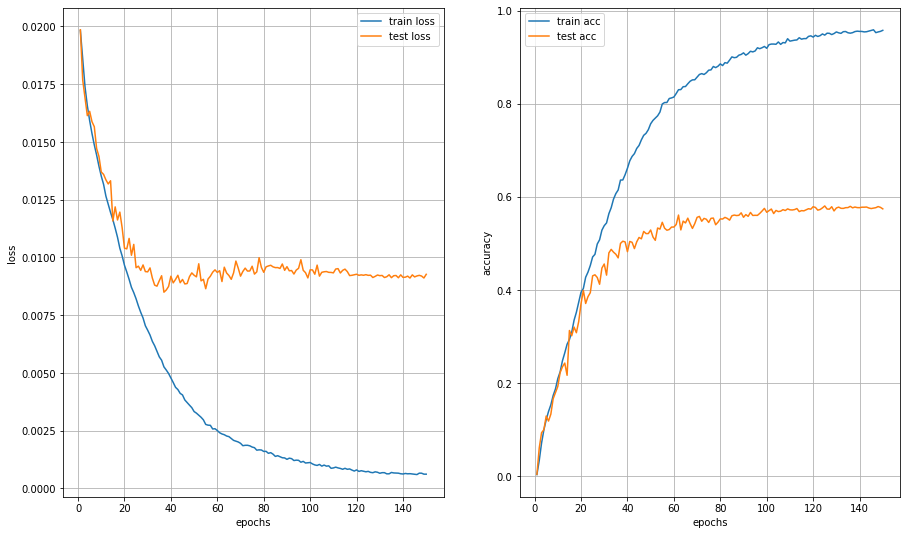

In [24]:
resnet_history = train_model(
    model, "resnet_cosine", 
    dataloaders["train"], dataloaders["val"], 150,
    criterion, optimizer, scheduler
)

In [31]:
np.array(resnet_history['test_acc']).max()

0.5803480040941658

Получили максимальный accuracy = 0.58034.

*Ну почти 0.6*

### 3. Реализуем свой Resnet-18

Блок Resnet

In [35]:
from collections import OrderedDict

In [36]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sampling=False):
        super().__init__()
        self.down_sampling = down_sampling
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                                stride=(1 if in_channels == out_channels else 2), padding=1,
                                bias=False)),
            ('bn1', nn.BatchNorm2d(out_channels)),
            ('relu1', nn.ReLU())
        ]))
        self.shortcut = nn.Sequential(OrderedDict([
            (
                'conv',
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, bias=False)),
            ('bn', nn.BatchNorm2d(out_channels))
        ])) if in_channels != out_channels else nn.Sequential()
        self.conv2 = nn.Sequential(OrderedDict([
            ('conv2', nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1,
                                bias=False)),
            ('bn2', nn.BatchNorm2d(out_channels))
        ]))
        self.relu2 = nn.ReLU()

    def forward(self, x):
        fx = self.conv1(x)
        fx = self.conv2(fx)
        x = self.shortcut(x)
        hx = fx + x
        hx = self.relu2(hx)
        return hx


Сам Резнет

In [39]:
class MyResnet18(nn.Module):
    def __init__(self, num_classes):
        super(MyResnet18, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)),
            ('bn', nn.BatchNorm2d(64)),
            ('relu', nn.ReLU()),
        ]))
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, down_sampling=False)
        self.layer2 = self.make_layer(64, 128)
        self.layer3 = self.make_layer(128, 256)
        self.layer4 = self.make_layer(256, 512)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    @staticmethod
    def make_layer(in_channels, out_channels, down_sampling=True):
        layer = nn.Sequential()
        layer.add_module('block1', ResnetBlock(in_channels, out_channels, down_sampling=down_sampling))
        layer.add_module('block2', ResnetBlock(out_channels, out_channels, down_sampling=False))
        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [40]:
my_model = MyResnet18(256)

In [41]:
sum(p.numel() for p in my_model.parameters() if p.requires_grad)

11307840

Количество параметров совпадает

In [42]:
optimizer = optim.AdamW(my_model.parameters())

In [43]:
scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=15, num_training_steps=150,
)

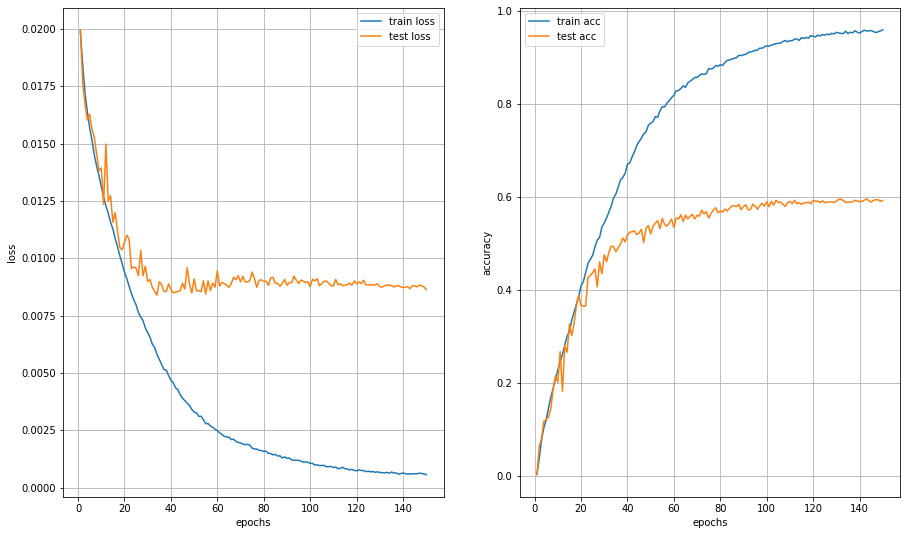

In [44]:
my_resnet_history = train_model(
    my_model, "my_resnet", 
    dataloaders["train"], dataloaders["val"], 150,
    criterion, optimizer, scheduler)

In [45]:
np.array(my_resnet_history['test_acc']).max()

0.5962128966223132

Получили accuracy чуть больше - 0.59621.

*(давайте округлим и будем считать что тут 0.6)*

Видать повезло с рандом сидом, ибо параметры обучения не менялись

### 4. Конвертация в ONNX

In [52]:
def convert_to_onnx(model, input_shape, output_path):
    dummy_input = torch.randn(input_shape)
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        opset_version=12,
        verbose=True,
        input_names = ['input'],
        output_names = ['output'],
        dynamic_axes={
            'input' : {0 : 'batch_size'}, 
            'output' : {0 : 'batch_size'},
        },
    )

In [53]:
convert_to_onnx(model.cpu(), (128, 3, 244, 244), "model_onnx.onnx")

In [54]:
convert_to_onnx(my_model.cpu(), (128, 3, 244, 244), "my_model_onnx.onnx")

### 5. Проверим, что ONNX модели работают также как и на Pytorch

Проверим один батч картинок. Если ответы моделей на торче и в оннх будут совпадать, то следовательно и метрики качества тоже.

In [55]:
images, labels = next(iter(dataloaders["val"]))

Проверим на оннх:

In [56]:
import onnxruntime as ort

options = ort.SessionOptions()
options.enable_profiling=True
sess = ort.InferenceSession("model_onnx.onnx", sess_options=options)
onnx_output = sess.run(["output"], {"input": images.numpy()})

Проверим на торче:

In [59]:
torch_output = model(images)

In [67]:
assert np.allclose(torch_output.detach().cpu().numpy(), onnx_output, atol=1e-5)

Модели работают одинаково!
Предсказания различаются только в шестом знаке после запятой

## Вывод

В данной лабораторной работе я решал задачу классификации картинок на 256 классов с помощью Resnet-18. Модель брал из торчвижен и реализовывал сам. Получил следующие результаты на валидацонной выборке:

accuracy (torchvision) = 0.5803

accuracy (моя реализация) = 0.5962

В работе были использованы следующие "трюки":
1. Взвешанный лосс - чем больше объектов класса, тем меньший у него вес
2. Аугментация фоток при обучении - рандомный флип и поворот
3. ЦентрКроп фоток - обрезаем края
4. Косинусоидальный лр шедулер (0.5 периода)
5. Прогрев лернинг рейта - первые несколько эпох лернинг рейт возрастает, затем применяется косинусоидальный шедулер

Что еще можно было использовать, чтобы поднять эккюраси:
1. Миксап
2. Сглаживание таргетов
3. Перейти от 32-битным флотам к 16-битным